# Voting systems

### Modeling elections as channels

We are gonna start with a simple example to set the scene. Consider the smallest election ever with just 3 voters and 2 candidates.  How can we model that using QIF terminology?

We know that a channel takes as input something secret and outputs something public. So what is secret in an election? The votes. But we have 3 persons voting. And each person has 2 possible options for his vote. So in total there are the following $2^3$ scenarios ($c_1$ and $c_2$ below stand for _candidate 1_ and _candidate 2_ respectively):

```
X = {
    c1 c1 c1, 
    c1 c1 c2, 
    c1 c2 c1, 
    c1 c2 c2, 
    c2 c1 c1, 
    c2 c1 c2, 
    c2 c2 c1, 
    c2 c2 c2, 
    }
```


And that is how we can model the votes as our channel's input $X$.

But what would the channel's output be? It depends. It could be just the name of the winning candidate; that is, the candidate which received the most votes. Or maybe it could be for each candidate, the votes they received. Or something else. For this example we are gonna examine channels that announce only the winner's name and nothing else. And the possible values for that output $Y$ are the candidates themselves, i.e.:

```
Y = { c1, c2 }
```

So for our example the complete channel would look like:

$$
\begin{array}{|c|c|c|}
\hline
W & c_1 & c_2 \\ \hline
c_1 c_1 c_1 & 1 & 0 \\ \hline
c_1 c_1 c_2 & 1 & 0 \\ \hline
c_1 c_2 c_1 & 1 & 0 \\ \hline
c_1 c_2 c_2 & 0 & 1 \\ \hline
c_2 c_1 c_1 & 1 & 0 \\ \hline
c_2 c_1 c_2 & 0 & 1 \\ \hline
c_2 c_2 c_1 & 0 & 1 \\ \hline
c_2 c_2 c_2 & 0 & 1 \\ \hline
\end{array}
$$

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
try:
    from qif import *
except: # install qif if not available (for running in colab, etc)
    import IPython; IPython.get_ipython().run_line_magic('pip', 'install qif')
    from qif import *

In [7]:
num_voters = 3
num_candidates = 2
num_combinations = num_candidates ** num_voters

In [9]:
def get_votes(combination, num_voters, num_candidates):
    votes = [0 for i in range(num_voters)]
    for i in range(num_voters):
        votes[num_voters - 1 - i] = combination % num_candidates 
        combination -= votes[num_voters - 1 - i]
        combination /= num_candidates
        combination = int(combination)
    return votes

def get_winner(votes):
    return max(set(votes), key=votes.count)

def get_W(num_voters, num_candidates):
    return np.array([[1 if j == get_winner(get_votes(i, num_voters, num_candidates)) else 0 for j in range(num_candidates)]  for i in range(num_candidates ** num_voters)])

In [10]:
pi = probab.uniform(num_combinations)
print(pi)

[0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]


In [6]:
print("Posterior bayes vulnerability:", measure.bayes_vuln.posterior(pi, W))
print("Multiplicative bayes leakage:", measure.bayes_vuln.mult_leakage(pi, W))

Posterior bayes vulnerability: 0.25
Multiplicative bayes leakage: 2.0


In [7]:
def g1(vote, voting_combination, num_voters, num_candidates):
    return int(vote[0] == get_votes(voting_combination, num_voters, num_candidates)[vote[1]])

g1((1, 1), 4, num_voters, num_candidates)

0

In [8]:
def get_G1(num_voters, num_candidates):
    return np.array([[g1((c, v), i, num_voters, num_candidates) for i in range(num_candidates ** num_voters)] for c,v in itertools.product(range(num_candidates), range(num_voters))])

G1 = get_G1(3, 2)
print("G1:\n", G1)

G1:
 [[1 1 1 1 0 0 0 0]
 [1 1 0 0 1 1 0 0]
 [1 0 1 0 1 0 1 0]
 [0 0 0 0 1 1 1 1]
 [0 0 1 1 0 0 1 1]
 [0 1 0 1 0 1 0 1]]


In [9]:
print("Posterior g vulnerability:", measure.g_vuln.posterior(G1, pi, W))
print("Multiplicative g leakage:", measure.g_vuln.mult_leakage(G1, pi, W))

Posterior g vulnerability: 0.75
Multiplicative g leakage: 1.5


In [10]:
def g0(vote, voting_combination, num_voters, num_candidates):
    return int(vote[0] != get_votes(voting_combination, num_voters, num_candidates)[vote[1]])

g0((1, 1), 4, num_voters, num_candidates)

1

In [11]:
def get_G0(num_voters, num_candidates):
    return np.array([[g0((c, v), i, num_voters, num_candidates) for i in range(num_candidates ** num_voters)] for c,v in itertools.product(range(num_candidates), range(num_voters))])

G0 = get_G0(3, 2)
print("G0:\n", G0)

G0:
 [[0 0 0 0 1 1 1 1]
 [0 0 1 1 0 0 1 1]
 [0 1 0 1 0 1 0 1]
 [1 1 1 1 0 0 0 0]
 [1 1 0 0 1 1 0 0]
 [1 0 1 0 1 0 1 0]]


In [12]:
print("Posterior g vulnerability:", measure.g_vuln.posterior(G0, pi, W))
print("Multiplicative g leakage:", measure.g_vuln.mult_leakage(G0, pi, W))

Posterior g vulnerability: 0.75
Multiplicative g leakage: 1.5


In [13]:
c = 3 # number of candidates
vs = [v for v in range(1, 10)]

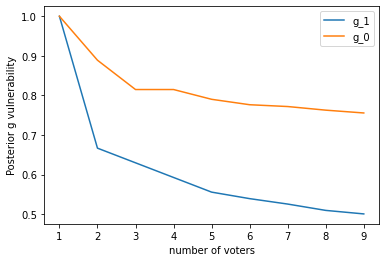

In [14]:
plt.plot(vs, [measure.g_vuln.posterior(get_G1(v, c), probab.uniform(c ** v), get_W(v, c)) for v in vs], label="g_1")
plt.plot(vs, [measure.g_vuln.posterior(get_G0(v, c), probab.uniform(c ** v), get_W(v, c)) for v in vs], label="g_0")
plt.xlabel('number of voters')
plt.ylabel('Posterior g vulnerability')
plt.legend()
None

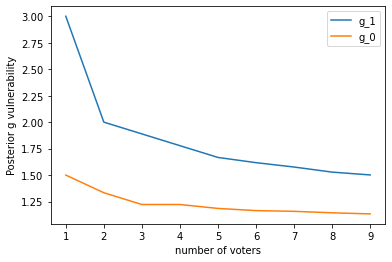

In [15]:
plt.plot(vs, [measure.g_vuln.mult_leakage(get_G1(v, c), probab.uniform(c ** v), get_W(v, c)) for v in vs], label="g_1")
plt.plot(vs, [measure.g_vuln.mult_leakage(get_G0(v, c), probab.uniform(c ** v), get_W(v, c)) for v in vs], label="g_0")
plt.xlabel('number of voters')
plt.ylabel('Posterior g vulnerability')
plt.legend()
None